# Week 15, Day 2: Multi-Head Attention for Financial Sequences

## Learning Objectives
1. Understand why multiple attention heads are beneficial
2. Master multi-head attention architecture and math
3. Implement multi-head attention from scratch in PyTorch
4. Build a complete Transformer encoder block
5. Apply to financial time series prediction

---

## 1. Why Multi-Head Attention?

### Limitations of Single-Head Attention

With single-head attention, the model learns **one** set of Q, K, V projections:
- Can only capture one "type" of relationship at a time
- Limited representation capacity
- All positions must share the same attention pattern

### Multi-Head Intuition: Multiple Perspectives

Multi-head attention allows the model to **jointly attend to information from different representation subspaces**:

```
Single Head:                    Multi-Head:
┌─────────────────┐            ┌─────────────────────────────┐
│ One attention   │            │ Head 1: Short-term momentum │
│ pattern for all │     vs     │ Head 2: Long-term trend     │
│ relationships   │            │ Head 3: Volatility patterns │
└─────────────────┘            │ Head 4: Mean reversion      │
                               └─────────────────────────────┘
```

### Trading Analogies for Multiple Heads

| Head | What It Might Learn |
|------|---------------------|
| Head 1 | Recent price momentum (last few days) |
| Head 2 | Weekly/monthly patterns |
| Head 3 | Volatility clustering |
| Head 4 | Support/resistance levels |
| Head 5 | Volume-price relationship |
| Head 6 | Trend reversals |

Each head can specialize in detecting different market dynamics!

## 2. Multi-Head Attention: Mathematical Formulation

### Architecture Overview

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

Where each head is:
$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

### Dimensions

For $h$ heads with model dimension $d_{model}$:
- $d_k = d_v = d_{model} / h$ (dimension per head)
- $W_i^Q, W_i^K \in \mathbb{R}^{d_{model} \times d_k}$
- $W_i^V \in \mathbb{R}^{d_{model} \times d_v}$
- $W^O \in \mathbb{R}^{hd_v \times d_{model}}$ (output projection)

### Visual Representation

```
Input (batch, seq, d_model=512)
         │
         ├──────────────────────────────────────────────┐
         │                                              │
    ┌────┴────┐  ┌────┴────┐  ┌────┴────┐         ┌────┴────┐
    │ Head 1  │  │ Head 2  │  │ Head 3  │   ...   │ Head 8  │
    │ d_k=64  │  │ d_k=64  │  │ d_k=64  │         │ d_k=64  │
    └────┬────┘  └────┬────┘  └────┬────┘         └────┬────┘
         │            │            │                   │
         └────────────┼────────────┼───────────────────┘
                      │ Concatenate │
                      ▼            ▼
                 (batch, seq, 8×64=512)
                      │
                ┌─────┴─────┐
                │ W_O Linear │
                └─────┬─────┘
                      │
                      ▼
            Output (batch, seq, 512)
```

### Why This Works

1. **Same computational cost**: Total parameters ≈ same as single large head
   - Single head: $W^Q, W^K, W^V \in \mathbb{R}^{d \times d}$ = $3d^2$
   - Multi-head ($h$ heads): $h \times 3 \times (d \times d/h)$ = $3d^2$

2. **Different subspaces**: Each head projects to different learned subspace

3. **Parallel computation**: All heads computed simultaneously

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.9.1


## 3. Implementing Multi-Head Attention from Scratch

In [2]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention mechanism.
    
    Paper: "Attention Is All You Need" (Vaswani et al., 2017)
    
    Args:
        d_model: Dimension of the model (input/output dimension)
        n_heads: Number of attention heads
        dropout: Dropout rate
    """
    def __init__(self, d_model, n_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads  # Dimension per head
        
        # Linear projections for Q, K, V (for all heads at once)
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = np.sqrt(self.d_k)
    
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (n_heads, d_k).
        Transpose to shape (batch, n_heads, seq_len, d_k)
        """
        x = x.view(batch_size, -1, self.n_heads, self.d_k)
        return x.transpose(1, 2)  # (batch, n_heads, seq_len, d_k)
    
    def forward(self, query, key, value, mask=None, return_attention=False):
        """
        Forward pass for multi-head attention.
        
        Args:
            query, key, value: (batch_size, seq_len, d_model)
            mask: Optional causal mask
            return_attention: Whether to return attention weights
        
        Returns:
            output: (batch_size, seq_len, d_model)
            attention_weights: (batch_size, n_heads, seq_len, seq_len)
        """
        batch_size = query.size(0)
        
        # 1. Linear projections
        Q = self.W_q(query)  # (batch, seq, d_model)
        K = self.W_k(key)
        V = self.W_v(value)
        
        # 2. Split into multiple heads
        Q = self.split_heads(Q, batch_size)  # (batch, n_heads, seq, d_k)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)
        
        # 3. Scaled dot-product attention for each head
        # (batch, n_heads, seq, d_k) @ (batch, n_heads, d_k, seq)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        # 4. Apply mask (if provided)
        if mask is not None:
            # Expand mask for heads dimension
            mask = mask.unsqueeze(0).unsqueeze(0)  # (1, 1, seq, seq)
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        # 5. Softmax and dropout
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # 6. Apply attention to values
        # (batch, n_heads, seq, seq) @ (batch, n_heads, seq, d_k)
        context = torch.matmul(attention_weights, V)  # (batch, n_heads, seq, d_k)
        
        # 7. Concatenate heads
        # Transpose back: (batch, seq, n_heads, d_k)
        context = context.transpose(1, 2).contiguous()
        # Reshape: (batch, seq, d_model)
        context = context.view(batch_size, -1, self.d_model)
        
        # 8. Final linear projection
        output = self.W_o(context)
        
        if return_attention:
            return output, attention_weights
        return output


# Test the implementation
print("=" * 60)
print("Multi-Head Attention Test")
print("=" * 60)

batch_size = 2
seq_len = 10
d_model = 64
n_heads = 8

mha = MultiHeadAttention(d_model=d_model, n_heads=n_heads)

# Sample input
x = torch.randn(batch_size, seq_len, d_model)

# Create causal mask
causal_mask = torch.tril(torch.ones(seq_len, seq_len))

# Forward pass
output, attn_weights = mha(x, x, x, mask=causal_mask, return_attention=True)

print(f"\nInput shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"  - batch_size: {batch_size}")
print(f"  - n_heads: {n_heads}")
print(f"  - seq_len x seq_len: {seq_len} x {seq_len}")
print(f"\nDimension per head (d_k): {mha.d_k}")

Multi-Head Attention Test

Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])
Attention weights shape: torch.Size([2, 8, 10, 10])
  - batch_size: 2
  - n_heads: 8
  - seq_len x seq_len: 10 x 10

Dimension per head (d_k): 8


## 4. Visualizing Multi-Head Attention Patterns

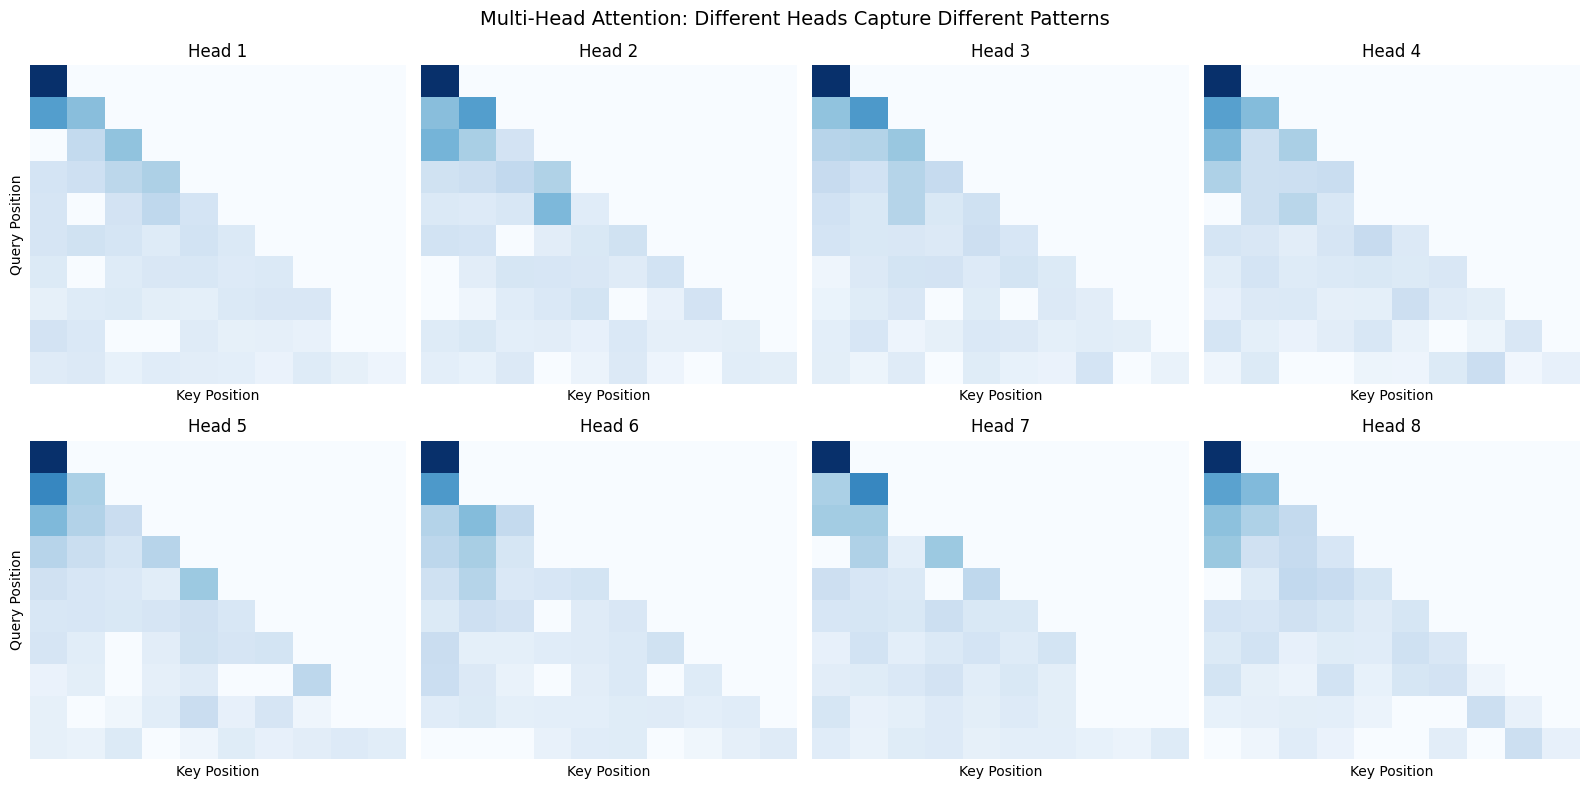


📊 Notice how different heads learn different attention patterns:
   - Some heads focus on recent positions (local patterns)
   - Some heads attend more broadly (global patterns)
   - Some heads show diagonal patterns (relative position focus)


In [3]:
# Visualize attention patterns from different heads
attn_np = attn_weights[0].detach().numpy()  # First sample

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Multi-Head Attention: Different Heads Capture Different Patterns', fontsize=14)

for i, ax in enumerate(axes.flat):
    sns.heatmap(attn_np[i], cmap='Blues', ax=ax, cbar=False,
                xticklabels=False, yticklabels=False)
    ax.set_title(f'Head {i+1}', fontsize=12)
    ax.set_xlabel('Key Position')
    if i % 4 == 0:
        ax.set_ylabel('Query Position')

plt.tight_layout()
plt.show()

print("\n📊 Notice how different heads learn different attention patterns:")
print("   - Some heads focus on recent positions (local patterns)")
print("   - Some heads attend more broadly (global patterns)")
print("   - Some heads show diagonal patterns (relative position focus)")

## 5. Complete Transformer Encoder Block

In [4]:
class PositionalEncoding(nn.Module):
    """
    Sinusoidal positional encoding from "Attention Is All You Need".
    
    PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    """
    def __init__(self, d_model, max_seq_len=500, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        
        # Create positional encoding matrix
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)  # Even dimensions
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd dimensions
        
        pe = pe.unsqueeze(0)  # (1, max_seq_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        Args:
            x: (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class FeedForward(nn.Module):
    """
    Position-wise Feed-Forward Network.
    
    FFN(x) = max(0, xW_1 + b_1)W_2 + b_2
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))


class TransformerEncoderBlock(nn.Module):
    """
    Single Transformer Encoder Block.
    
    Components:
    1. Multi-Head Self-Attention
    2. Add & Norm (Residual + Layer Norm)
    3. Feed-Forward Network
    4. Add & Norm (Residual + Layer Norm)
    """
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        
        self.self_attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x, mask=None, return_attention=False):
        """
        Args:
            x: (batch_size, seq_len, d_model)
            mask: Optional causal mask
        """
        # Self-attention with residual connection and layer norm
        if return_attention:
            attn_output, attn_weights = self.self_attention(
                x, x, x, mask=mask, return_attention=True
            )
        else:
            attn_output = self.self_attention(x, x, x, mask=mask)
        
        x = self.norm1(x + self.dropout1(attn_output))
        
        # Feed-forward with residual connection and layer norm
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))
        
        if return_attention:
            return x, attn_weights
        return x


# Visualize the Transformer block architecture
print("""
Transformer Encoder Block Architecture:
========================================

Input (batch, seq, d_model)
        │
        ├──────────────────┐
        │                  │ (Residual)
        ▼                  │
┌───────────────────┐      │
│  Multi-Head       │      │
│  Self-Attention   │      │
└───────────────────┘      │
        │                  │
        ▼                  │
    Dropout               │
        │                  │
        └────────► + ◄────┘
                   │
                   ▼
           Layer Norm
                   │
        ├──────────┴──────────┐
        │                     │ (Residual)
        ▼                     │
┌───────────────────┐         │
│  Feed-Forward     │         │
│  Network          │         │
└───────────────────┘         │
        │                     │
        ▼                     │
    Dropout                  │
        │                     │
        └────────► + ◄───────┘
                   │
                   ▼
           Layer Norm
                   │
                   ▼
        Output (batch, seq, d_model)
""")


Transformer Encoder Block Architecture:

Input (batch, seq, d_model)
        │
        ├──────────────────┐
        │                  │ (Residual)
        ▼                  │
┌───────────────────┐      │
│  Multi-Head       │      │
│  Self-Attention   │      │
└───────────────────┘      │
        │                  │
        ▼                  │
    Dropout               │
        │                  │
        └────────► + ◄────┘
                   │
                   ▼
           Layer Norm
                   │
        ├──────────┴──────────┐
        │                     │ (Residual)
        ▼                     │
┌───────────────────┐         │
│  Feed-Forward     │         │
│  Network          │         │
└───────────────────┘         │
        │                     │
        ▼                     │
    Dropout                  │
        │                     │
        └────────► + ◄───────┘
                   │
                   ▼
           Layer Norm
                   │


## 6. Full Transformer Model for Financial Time Series

In [5]:
class TransformerForecaster(nn.Module):
    """
    Transformer-based model for financial time series forecasting.
    
    Architecture:
    - Input projection
    - Positional encoding
    - N Transformer encoder blocks
    - Global average pooling or last position
    - Prediction head
    """
    def __init__(self, input_dim=1, d_model=64, n_heads=4, n_layers=2, 
                 d_ff=256, seq_length=30, dropout=0.1, output_dim=1):
        super(TransformerForecaster, self).__init__()
        
        self.seq_length = seq_length
        self.d_model = d_model
        
        # Input embedding
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, seq_length, dropout)
        
        # Transformer encoder blocks
        self.encoder_blocks = nn.ModuleList([
            TransformerEncoderBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        # Prediction head
        self.fc1 = nn.Linear(d_model, d_model // 2)
        self.fc2 = nn.Linear(d_model // 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Causal mask (registered as buffer)
        self.register_buffer('causal_mask', torch.tril(torch.ones(seq_length, seq_length)))
    
    def forward(self, x, return_attention=False):
        """
        Args:
            x: (batch_size, seq_length, input_dim)
        
        Returns:
            output: (batch_size, output_dim)
            attention_weights: List of attention weights from each layer
        """
        attention_weights_list = []
        
        # Input projection and positional encoding
        x = self.input_projection(x)  # (batch, seq, d_model)
        x = self.positional_encoding(x)
        
        # Pass through encoder blocks
        for encoder in self.encoder_blocks:
            if return_attention:
                x, attn_weights = encoder(x, mask=self.causal_mask, return_attention=True)
                attention_weights_list.append(attn_weights)
            else:
                x = encoder(x, mask=self.causal_mask)
        
        # Use last position for prediction (autoregressive)
        x = x[:, -1, :]  # (batch, d_model)
        
        # Prediction head
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        output = self.fc2(x)  # (batch, output_dim)
        
        if return_attention:
            return output, attention_weights_list
        return output


# Initialize model
SEQ_LENGTH = 30
model = TransformerForecaster(
    input_dim=1,
    d_model=64,
    n_heads=4,
    n_layers=2,
    d_ff=256,
    seq_length=SEQ_LENGTH,
    dropout=0.1
).to(device)

print("Transformer Forecaster Architecture:")
print("=" * 50)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Transformer Forecaster Architecture:
TransformerForecaster(
  (input_projection): Linear(in_features=1, out_features=64, bias=True)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_blocks): ModuleList(
    (0-1): 2 x TransformerEncoderBlock(
      (self_attention): MultiHeadAttention(
        (W_q): Linear(in_features=64, out_features=64, bias=True)
        (W_k): Linear(in_features=64, out_features=64, bias=True)
        (W_v): Linear(in_features=64, out_features=64, bias=True)
        (W_o): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps

## 7. Load Financial Data and Prepare for Training

In [6]:
# Download financial data
print("Downloading stock data...")
ticker = "AAPL"
df = yf.download(ticker, start="2018-01-01", end="2024-01-01", progress=False)

# Use Close price
prices = df['Close'].values.reshape(-1, 1)

print(f"\nDataset: {ticker}")
print(f"Date range: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Total samples: {len(prices)}")

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Create sequences
def create_sequences(data, seq_length, pred_horizon=1):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_horizon + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length + pred_horizon - 1])
    return np.array(X), np.array(y)

X, y = create_sequences(prices_scaled, SEQ_LENGTH)

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to tensors
X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.FloatTensor(y_train).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
y_test_t = torch.FloatTensor(y_test).to(device)

print(f"\nSequence length: {SEQ_LENGTH}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"X_train shape: {X_train_t.shape}")


Dataset: AAPL
Date range: 2018-01-02 to 2023-12-29
Total samples: 1509

Sequence length: 30
Training samples: 1183
Test samples: 296
X_train shape: torch.Size([1183, 30, 1])


## 8. Training the Transformer Model

Training Transformer Model...
Epoch [20/100] - Train Loss: 0.002264, Val Loss: 0.001547, LR: 0.000905

Early stopping at epoch 39

✅ Training complete! Best model loaded.


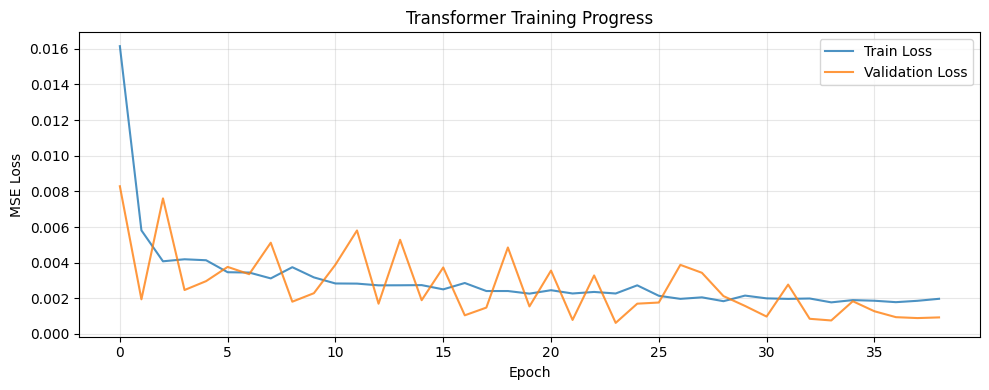

In [7]:
# Training configuration
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# Create DataLoader
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
n_epochs = 100
train_losses = []
val_losses = []

print("Training Transformer Model...")
print("=" * 50)

best_val_loss = float('inf')
patience_counter = 0
patience = 15

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
    
    scheduler.step()
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_test_t)
        val_loss = criterion(val_output, y_test_t).item()
        val_losses.append(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_transformer.pt')
    else:
        patience_counter += 1
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {avg_train_loss:.6f}, "
              f"Val Loss: {val_loss:.6f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(torch.load('best_transformer.pt'))
print("\n✅ Training complete! Best model loaded.")

# Plot training curves
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Transformer Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Analyzing Multi-Head Attention Patterns

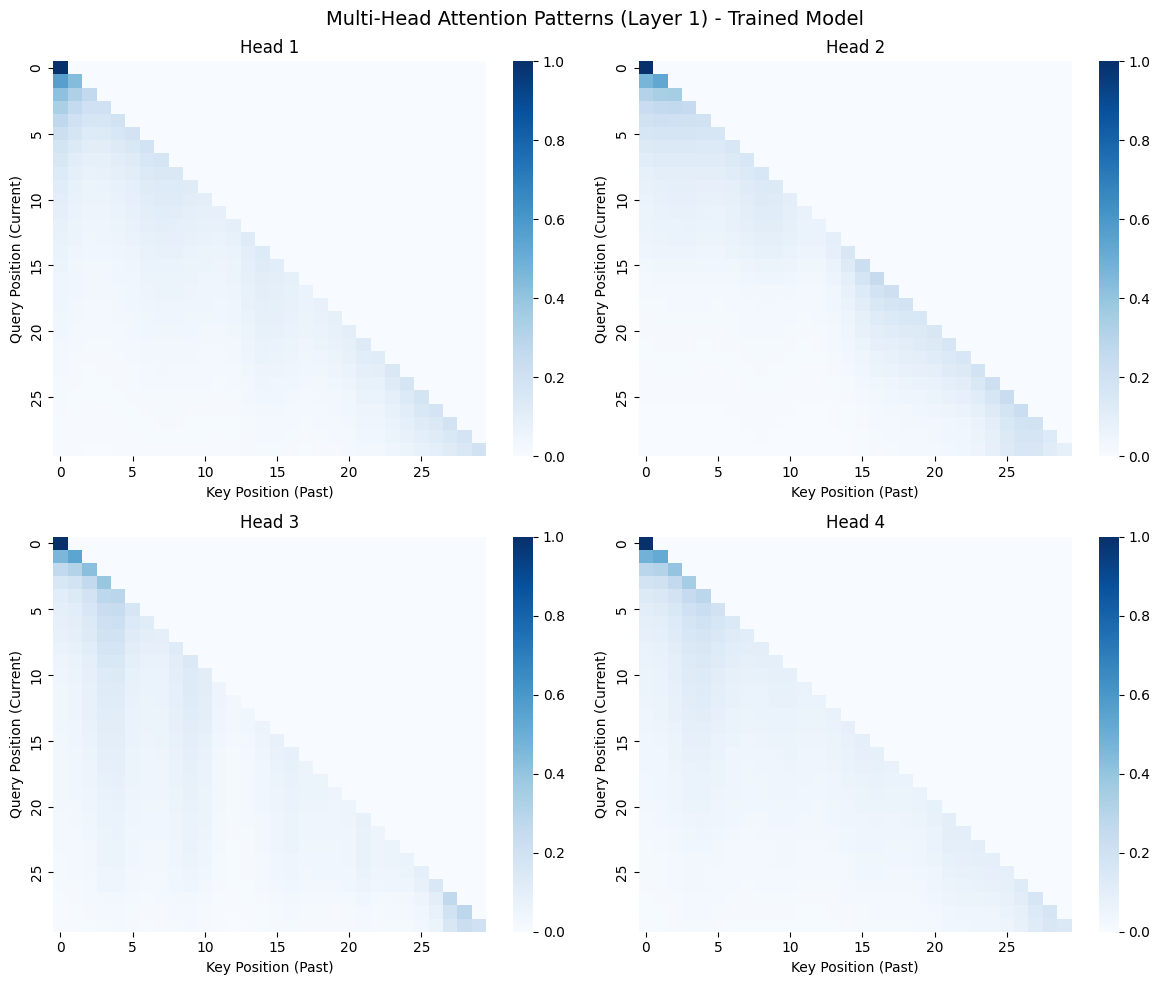


Analysis: What Each Head Focuses On (Last Position)

Head 1:
  Top attended positions: [29 28 27]
  Recent focus (last 5): 0.642
  Distant focus (first 10): 0.055
  Entropy (higher = more spread): 2.685

Head 2:
  Top attended positions: [26 27 25]
  Recent focus (last 5): 0.643
  Distant focus (first 10): 0.024
  Entropy (higher = more spread): 2.574

Head 3:
  Top attended positions: [28 29 27]
  Recent focus (last 5): 0.678
  Distant focus (first 10): 0.136
  Entropy (higher = more spread): 2.598

Head 4:
  Top attended positions: [28 29 27]
  Recent focus (last 5): 0.549
  Distant focus (first 10): 0.120
  Entropy (higher = more spread): 2.916


In [8]:
# Get attention weights from the trained model
model.eval()
with torch.no_grad():
    # Use a sample of test data
    sample_X = X_test_t[:10]
    predictions, attention_layers = model(sample_X, return_attention=True)

# Attention from first layer, first sample
attn_layer1 = attention_layers[0][0].cpu().numpy()  # (n_heads, seq, seq)

# Plot attention from each head
n_heads = attn_layer1.shape[0]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Multi-Head Attention Patterns (Layer 1) - Trained Model', fontsize=14)

for i, ax in enumerate(axes.flat):
    sns.heatmap(attn_layer1[i], cmap='Blues', ax=ax,
                xticklabels=5, yticklabels=5)
    ax.set_title(f'Head {i+1}', fontsize=12)
    ax.set_xlabel('Key Position (Past)')
    ax.set_ylabel('Query Position (Current)')

plt.tight_layout()
plt.show()

# Analyze what each head focuses on (for last prediction position)
print("\n" + "=" * 60)
print("Analysis: What Each Head Focuses On (Last Position)")
print("=" * 60)

for head_idx in range(n_heads):
    last_row = attn_layer1[head_idx, -1, :]  # Attention for final prediction
    
    # Find peak positions
    top_3 = np.argsort(last_row)[-3:][::-1]
    
    # Calculate focus metrics
    recent_focus = last_row[-5:].sum()  # Last 5 positions
    distant_focus = last_row[:10].sum()  # First 10 positions
    entropy = -np.sum(last_row * np.log(last_row + 1e-10))  # Attention entropy
    
    print(f"\nHead {head_idx + 1}:")
    print(f"  Top attended positions: {top_3}")
    print(f"  Recent focus (last 5): {recent_focus:.3f}")
    print(f"  Distant focus (first 10): {distant_focus:.3f}")
    print(f"  Entropy (higher = more spread): {entropy:.3f}")

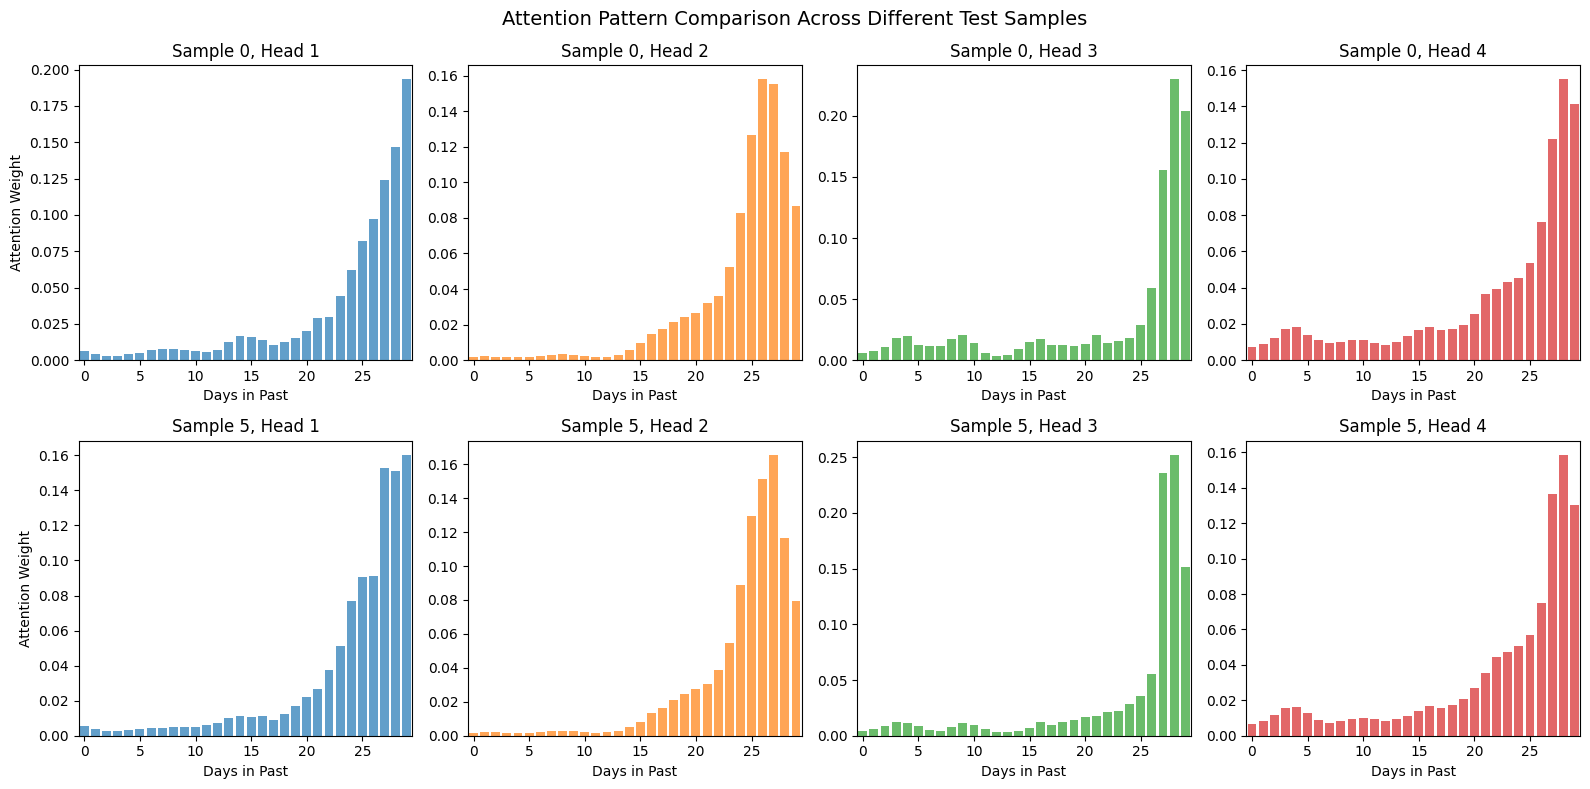

In [9]:
# Compare attention patterns across multiple samples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Attention Pattern Comparison Across Different Test Samples', fontsize=14)

# Get attention for different samples
sample_indices = [0, 5]

for row, sample_idx in enumerate(sample_indices):
    attn_sample = attention_layers[0][sample_idx].cpu().numpy()
    
    for head_idx in range(4):
        ax = axes[row, head_idx]
        
        # Plot last row (what the model attends to for prediction)
        last_row = attn_sample[head_idx, -1, :]
        ax.bar(range(SEQ_LENGTH), last_row, color=f'C{head_idx}', alpha=0.7)
        ax.set_title(f'Sample {sample_idx}, Head {head_idx+1}')
        ax.set_xlabel('Days in Past')
        if head_idx == 0:
            ax.set_ylabel('Attention Weight')
        ax.set_xlim(-0.5, SEQ_LENGTH - 0.5)

plt.tight_layout()
plt.show()

## 10. Model Evaluation and Comparison

In [10]:
# Generate predictions
model.eval()
with torch.no_grad():
    train_preds = model(X_train_t).cpu().numpy()
    test_preds = model(X_test_t).cpu().numpy()

# Inverse transform
train_preds_actual = scaler.inverse_transform(train_preds)
test_preds_actual = scaler.inverse_transform(test_preds)
y_train_actual = scaler.inverse_transform(y_train)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_preds_actual))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_preds_actual))
train_mae = mean_absolute_error(y_train_actual, train_preds_actual)
test_mae = mean_absolute_error(y_test_actual, test_preds_actual)

# MAPE
train_mape = np.mean(np.abs((y_train_actual - train_preds_actual) / y_train_actual)) * 100
test_mape = np.mean(np.abs((y_test_actual - test_preds_actual) / y_test_actual)) * 100

# Directional accuracy
y_test_returns = np.diff(y_test_actual.flatten())
pred_returns = np.diff(test_preds_actual.flatten())
directional_accuracy = np.mean((y_test_returns > 0) == (pred_returns > 0)) * 100

print("=" * 60)
print("Transformer Model Performance")
print("=" * 60)
print(f"\n{'Metric':<20} {'Train':>12} {'Test':>12}")
print("-" * 45)
print(f"{'RMSE ($)':<20} {train_rmse:>12.2f} {test_rmse:>12.2f}")
print(f"{'MAE ($)':<20} {train_mae:>12.2f} {test_mae:>12.2f}")
print(f"{'MAPE (%)':<20} {train_mape:>12.2f} {test_mape:>12.2f}")
print(f"{'Dir. Accuracy (%)':20} {'-':>12} {directional_accuracy:>12.2f}")

Transformer Model Performance

Metric                      Train         Test
---------------------------------------------
RMSE ($)                     3.50         4.05
MAE ($)                      2.74         3.37
MAPE (%)                     3.51         2.07
Dir. Accuracy (%)               -        53.22


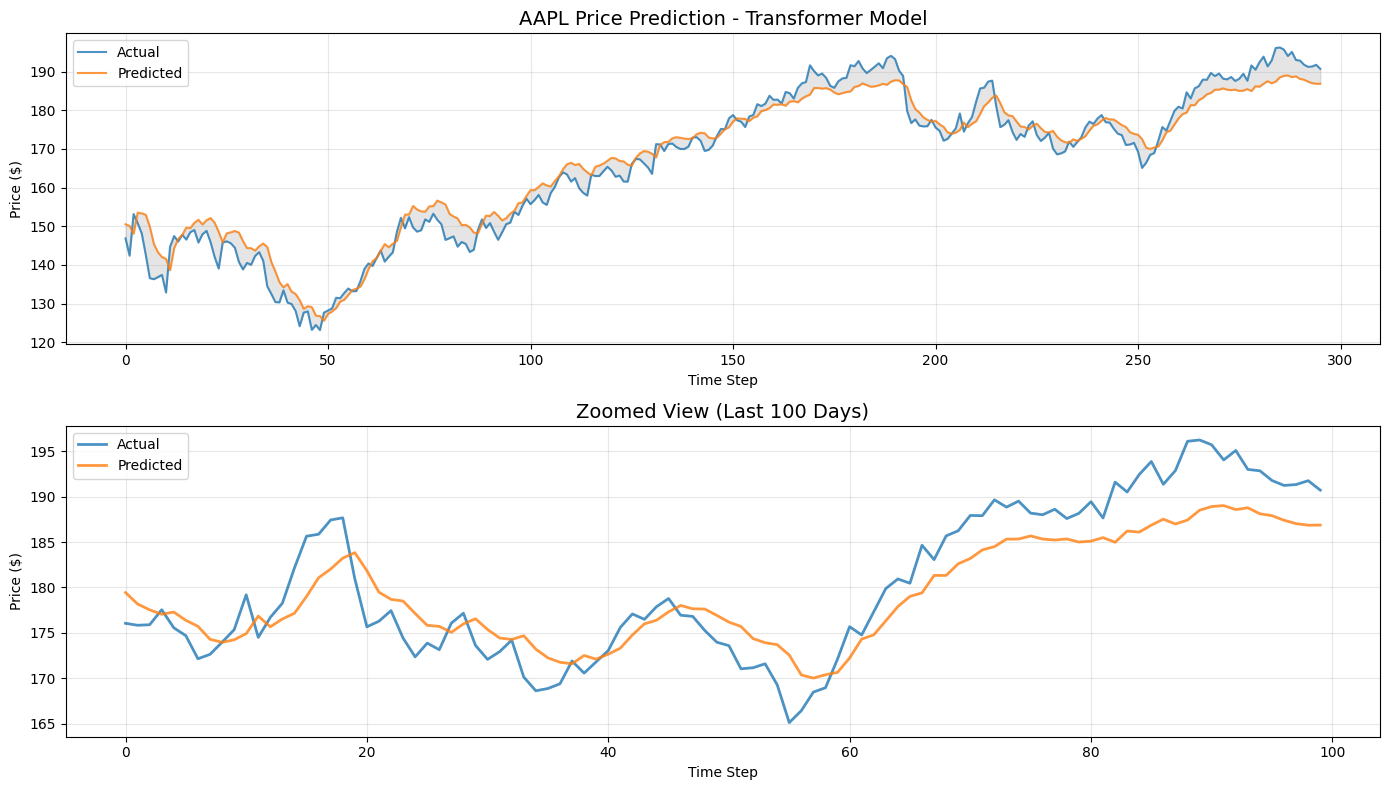

In [11]:
# Plot predictions
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Full prediction plot
axes[0].plot(y_test_actual, label='Actual', alpha=0.8, linewidth=1.5)
axes[0].plot(test_preds_actual, label='Predicted', alpha=0.8, linewidth=1.5)
axes[0].fill_between(range(len(y_test_actual)), 
                     y_test_actual.flatten(), 
                     test_preds_actual.flatten(),
                     alpha=0.2, color='gray')
axes[0].set_title(f'{ticker} Price Prediction - Transformer Model', fontsize=14)
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Zoomed view (last 100 points)
zoom_range = slice(-100, None)
axes[1].plot(y_test_actual[zoom_range], label='Actual', alpha=0.8, linewidth=2)
axes[1].plot(test_preds_actual[zoom_range], label='Predicted', alpha=0.8, linewidth=2)
axes[1].set_title('Zoomed View (Last 100 Days)', fontsize=14)
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Price ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Comparison: Single-Head vs Multi-Head Attention

In [12]:
# Quick comparison model with single head
class SingleHeadTransformer(nn.Module):
    def __init__(self, input_dim=1, d_model=64, seq_length=30, dropout=0.1):
        super(SingleHeadTransformer, self).__init__()
        
        self.seq_length = seq_length
        self.d_model = d_model
        
        self.input_projection = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, seq_length, dropout)
        
        # Single head attention (n_heads=1)
        self.attention = MultiHeadAttention(d_model, n_heads=1, dropout=dropout)
        self.norm = nn.LayerNorm(d_model)
        
        self.fc1 = nn.Linear(d_model, d_model // 2)
        self.fc2 = nn.Linear(d_model // 2, 1)
        self.dropout = nn.Dropout(dropout)
        
        self.register_buffer('causal_mask', torch.tril(torch.ones(seq_length, seq_length)))
    
    def forward(self, x):
        x = self.input_projection(x)
        x = self.positional_encoding(x)
        attn_out = self.attention(x, x, x, mask=self.causal_mask)
        x = self.norm(x + attn_out)
        x = x[:, -1, :]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


# Train single-head model
single_head_model = SingleHeadTransformer(seq_length=SEQ_LENGTH).to(device)
single_optimizer = torch.optim.Adam(single_head_model.parameters(), lr=0.001)

print("Training Single-Head Model for Comparison...")
single_losses = []

for epoch in range(50):
    single_head_model.train()
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        single_optimizer.zero_grad()
        output = single_head_model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        single_optimizer.step()
        epoch_loss += loss.item()
    
    single_losses.append(epoch_loss / len(train_loader))

# Evaluate single-head
single_head_model.eval()
with torch.no_grad():
    single_test_preds = single_head_model(X_test_t).cpu().numpy()

single_test_preds_actual = scaler.inverse_transform(single_test_preds)
single_rmse = np.sqrt(mean_squared_error(y_test_actual, single_test_preds_actual))
single_mape = np.mean(np.abs((y_test_actual - single_test_preds_actual) / y_test_actual)) * 100

print("\n" + "=" * 60)
print("Single-Head vs Multi-Head Comparison")
print("=" * 60)
print(f"\n{'Model':<25} {'Test RMSE':>15} {'Test MAPE':>15}")
print("-" * 55)
print(f"{'Single-Head (1 head)':<25} ${single_rmse:>14.2f} {single_mape:>14.2f}%")
print(f"{'Multi-Head (4 heads)':<25} ${test_rmse:>14.2f} {test_mape:>14.2f}%")

improvement = (single_rmse - test_rmse) / single_rmse * 100
print(f"\n🎯 Multi-Head Improvement: {improvement:.2f}% lower RMSE")

Training Single-Head Model for Comparison...

Single-Head vs Multi-Head Comparison

Model                           Test RMSE       Test MAPE
-------------------------------------------------------
Single-Head (1 head)      $          4.71           2.28%
Multi-Head (4 heads)      $          4.05           2.07%

🎯 Multi-Head Improvement: 13.98% lower RMSE


## 12. Key Takeaways

### What We Learned

1. **Multi-Head Attention Benefits**
   - Multiple attention heads capture different relationship types
   - Same computational cost as single large head
   - Each head learns specialized attention patterns

2. **Architecture Components**
   - Multi-head attention: Parallel attention operations
   - Positional encoding: Inject sequence order information
   - Feed-forward network: Non-linear transformation
   - Residual connections + Layer normalization: Training stability

3. **Key Formulas**
   $$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$
   $$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

4. **Financial Applications**
   - Different heads can learn short-term vs long-term patterns
   - Interpretable: analyze which time periods each head focuses on
   - Foundation for more complex architectures (full Transformer, etc.)

---

### Interview Questions

1. **Why use multiple attention heads instead of one larger head?**
   - Multiple heads learn different representations/relationships
   - Same total parameters but more expressive
   - Different heads can specialize (local vs global patterns)

2. **What is the purpose of the output projection $W^O$?**
   - Combines information from all heads
   - Projects concatenated outputs back to model dimension
   - Allows heads to collaborate

3. **Why do Transformers need positional encoding?**
   - Self-attention is permutation-invariant
   - Without position info, model can't distinguish [A,B,C] from [C,A,B]
   - Critical for sequence modeling

4. **Why use layer normalization instead of batch normalization?**
   - Works with variable sequence lengths
   - More stable for recurrent/attention architectures
   - Independent of batch size

In [13]:
# Summary
print("\n" + "=" * 60)
print("Day 2 Summary: Multi-Head Attention")
print("=" * 60)
print(f"""
✅ Concepts Covered:
   • Multi-Head Attention mechanism
   • Query, Key, Value projections per head
   • Transformer Encoder block architecture
   • Positional encoding (sinusoidal)

✅ Implementation:
   • Transformer model: {total_params:,} parameters
   • Configuration: {model.d_model} dim, 4 heads, 2 layers
   • Test RMSE: ${test_rmse:.2f}
   • Test MAPE: {test_mape:.2f}%

📚 Key Formula:
   MultiHead(Q, K, V) = Concat(head₁, ..., headₕ)W^O
   head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)

🎯 Key Insight:
   Multiple heads capture different types of dependencies,
   improving model expressiveness without extra computation.
""")


Day 2 Summary: Multi-Head Attention

✅ Concepts Covered:
   • Multi-Head Attention mechanism
   • Query, Key, Value projections per head
   • Transformer Encoder block architecture
   • Positional encoding (sinusoidal)

✅ Implementation:
   • Transformer model: 102,209 parameters
   • Configuration: 64 dim, 4 heads, 2 layers
   • Test RMSE: $4.05
   • Test MAPE: 2.07%

📚 Key Formula:
   MultiHead(Q, K, V) = Concat(head₁, ..., headₕ)W^O
   head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)

🎯 Key Insight:
   Multiple heads capture different types of dependencies,
   improving model expressiveness without extra computation.

